# Analysis and Sampling of Molecular Simulations by adversarial Autoencoders
---
1. [Packages import](#1.-Packages-import)
2. [Internal coordinates computation](#2.-Internal-coordinates-computation)
3. [Execution & visualization](#3.-Execution-&-visualization)

## 1. Packages import

In [1]:
# Import packages

from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras import backend as kb
import keras as krs

from scipy.stats import multivariate_normal, gaussian_kde
from tensorflow.keras.optimizers import Adam
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from src import asmsa
from src import gan
import mdtraj as md
import numpy as np

In [2]:
# Define input files
%cd ~

# input conformation
conf = "alaninedipeptide_H.pdb"

# input trajectory
traj = "alaninedipeptide_reduced.xtc"

# input topology
topol = "topol.top"

/home/jovyan


## 2. Internal coordinates computation

In [3]:
tr = md.load(traj,top=conf)
geom = np.moveaxis(tr.xyz ,0,-1)

In [4]:
# Define sparse and dense feture extensions of IC
density = 2 # integer in [1, n_atoms-1]
sparse_dists = asmsa.NBDistancesSparse(geom.shape[0], density=density)
dense_dists = asmsa.NBDistancesDense(geom.shape[0])

# mol = asmsa.Molecule(conf,topol)
mol = asmsa.Molecule(conf,topol,fms=[sparse_dists])

In [5]:
X_train = mol.intcoord(geom).T
X_train.shape

(100001, 208)

## 3. Execution & visualization

In [6]:
# Execute

if __name__ == '__main__':
    gan = gan.GAN(X_train, 'lows.txt')
    
    test = gan.train(epochs=500, batch_size=132) 

2022-07-22 14:46:28.242795: W tensorflow/stream_executor/platform/default/dso_loader.cc:65] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-07-22 14:46:28.242823: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-22 14:46:28.242849: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-xvisnov1--467814-2dasmsa-2ddvxa54tp): /proc/driver/nvidia/version does not exist
14:46:28 INFO: Model: "sequential"
14:46:28 INFO: _________________________________________________________________
14:46:28 INFO:  Layer (type)                Output Shape              Param #   
14:46:28 INFO: =================================================================
14:46:28 INFO:  f

/home/jovyan
/home/jovyan/visualization


<Figure size 432x288 with 0 Axes>

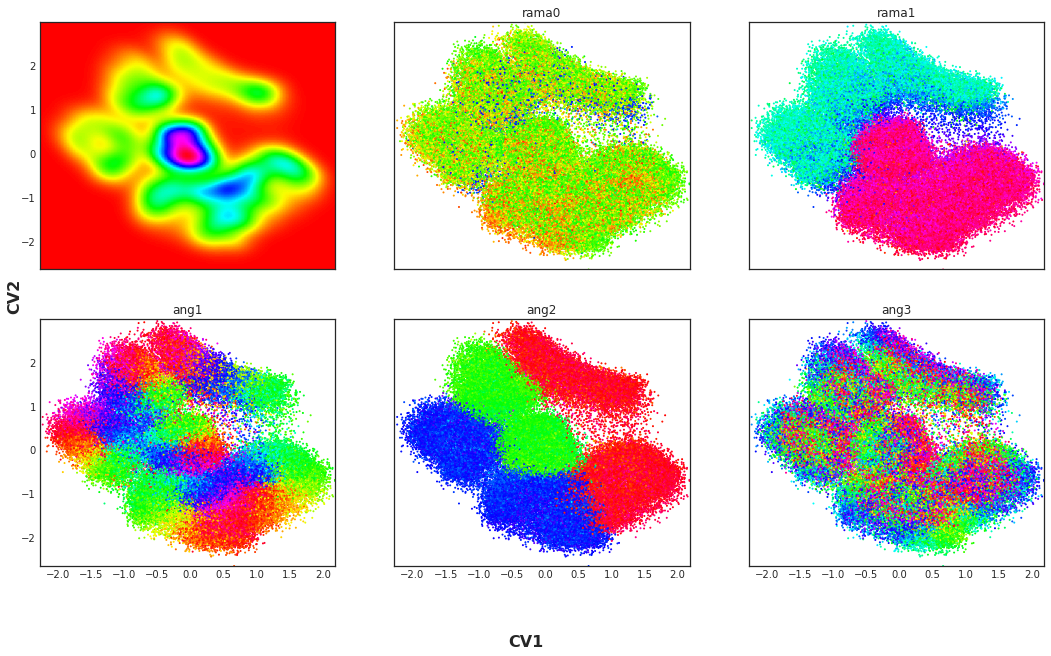

In [7]:
# Visualization of low dimensional space

# define input files
%cd ~
lows = np.loadtxt('lows.txt')

%cd visualization
rama_ala = np.loadtxt('rama_ala_reduced.txt', usecols=(0,1))
angever1 = np.loadtxt('angever1.txt')
angever2 = np.loadtxt('angever2.txt')
angever3 = np.loadtxt('angever3.txt')


cvs = (lows[:, 0], lows[:, 1])
analysis_files = {
    'rama0' : rama_ala[:, 0],
    'rama1' : rama_ala[:, 1],
    'ang1' : angever1[:, 1],
    'ang2' : angever2[:, 1],
    'ang3' : angever3[:, 1]
}

# set limits
xmin, xmax = min(cvs[0]), max(cvs[0])
ymin, ymax = min(cvs[1]), max(cvs[1])

# plot configuration
plt.suptitle('Low Dimentional Space - Analysis')
plt.style.use("seaborn-white")
fig = plt.figure(figsize=(18, 10))
fig.supxlabel('CV1', x=0.5, fontsize=16, fontweight='bold')
fig.supylabel('CV2', x=0.1, fontsize=16, fontweight='bold')

# plot first graph
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X; pos[:, :, 1] = Y
values = np.vstack([cvs[0], cvs[1]])
kernel = gaussian_kde(values)
dens = np.reshape(kernel(positions).T, X.shape)
ax1 = plt.subplot(2, 3, 1)
ax1.set_xticks([])
plt.imshow(np.rot90(dens), cmap="hsv", aspect="auto", extent=[xmin, xmax, ymin, ymax])


# plot every other graph
i = 2
for name, data in analysis_files.items():
    ax = plt.subplot(2, 3, i)
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.set_title(name)
    if i in [2,3,5,6]:
        ax.set_yticks([])
    if i in [2,3]:
        ax.set_xticks([])
    plt.scatter(cvs[0], cvs[1], s=1, c=data, cmap="hsv")
    i += 1

    
# you can view .png output in visualization folder
plt.savefig('analysis.png')